# Explore here

## 1) Import required libraries

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore')

## 2) Load dataset
Load dataset and set Date as index

In [71]:
# Load dataset
df = pd.read_csv('./Aquifer_Auser.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)

## 3) Identify correct groundwater column

In [72]:
# Identify Correct Groundwater Column
groundwater_columns = [
    'Depth_to_Groundwater_LT2', 'Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_PAG',
    'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_DIEC'
]

# Select the first available groundwater column
gw_column = next((col for col in groundwater_columns if col in df.columns), None)
if gw_column is None:
    raise ValueError("No valid groundwater column found in the dataset!")

print(f"Using column: {gw_column} for analysis")

Using column: Depth_to_Groundwater_LT2 for analysis


## 4) Exploratory data analysis

### 4.1) Data screening

In [73]:
## Dataset Overview
print("Dataset Overview:")
print(df.info())

## Summary Statistics
print("\nSummary Statistics:")
print(df.describe())

## Missing Values Analysis
print("\nMissing Values:")
print(df.isnull().sum())

# Handle Missing Values
## Interpolation to fill missing values
df[gw_column] = df[gw_column].interpolate()

# Ensure no NaN values remain after interpolation
df.dropna(subset=[gw_column], inplace=True)

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8154 entries, 1998-03-05 to 2020-06-30
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Rainfall_Gallicano                       5295 non-null   float64
 1   Rainfall_Pontetetto                      5295 non-null   float64
 2   Rainfall_Monte_Serra                     5289 non-null   float64
 3   Rainfall_Orentano                        5295 non-null   float64
 4   Rainfall_Borgo_a_Mozzano                 5295 non-null   float64
 5   Rainfall_Piaggione                       4930 non-null   float64
 6   Rainfall_Calavorno                       5295 non-null   float64
 7   Rainfall_Croce_Arcana                    5295 non-null   float64
 8   Rainfall_Tereglio_Coreglia_Antelminelli  5295 non-null   float64
 9   Rainfall_Fabbriche_di_Vallico            5295 non-null   float64
 10  Depth_to_Gro

### 4.2) Handling outliers

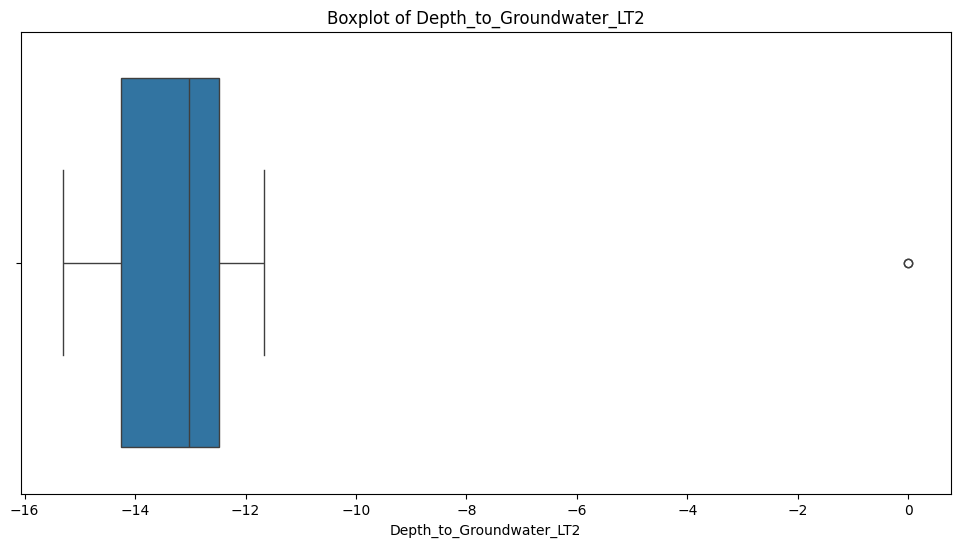

In [74]:
# Detecting and Handling Outliers
plt.figure(figsize=(12,6))
sns.boxplot(x=df[gw_column])
plt.title(f'Boxplot of {gw_column}')
plt.show()

# Removing outliers using the IQR method
Q1 = df[gw_column].quantile(0.25)
Q3 = df[gw_column].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df[gw_column] >= lower_bound) & (df[gw_column] <= upper_bound)]


### 4.3) Univariate data analysis (data visualization)

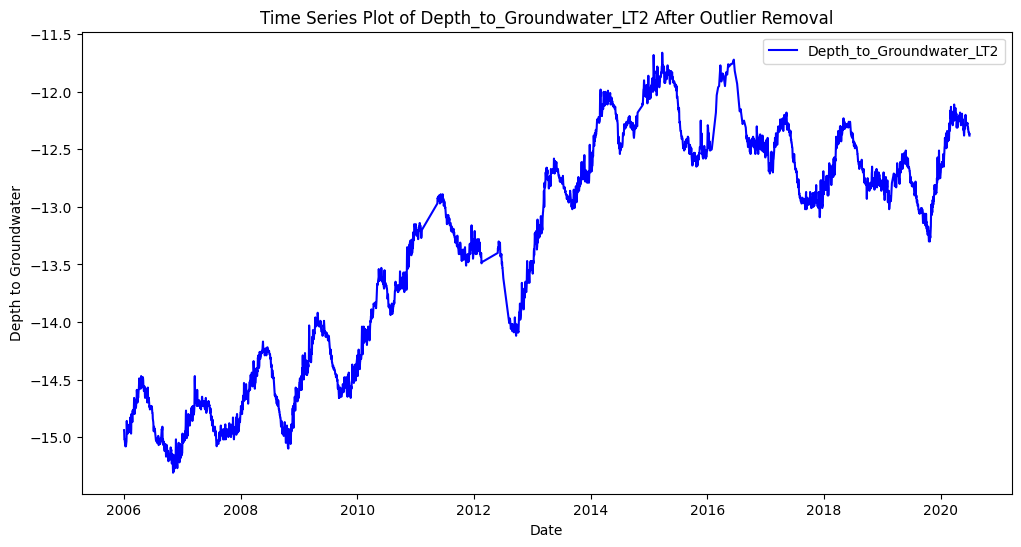

In [75]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df[gw_column], label=gw_column, color='blue')
plt.xlabel('Date')
plt.ylabel('Depth to Groundwater')
plt.title(f'Time Series Plot of {gw_column} After Outlier Removal')
plt.legend()
plt.show()

### Conclusions of univariate data analysis
- The time series plot shows a **clear seasonal trend** in groundwater levels.
- There are **periodic fluctuations**, likely influenced by rainfall patterns.
- Some anomalies (sharp drops or rises) may correspond to **extreme weather events** or data collection issues.


### 4.4) Multivariate data analysis

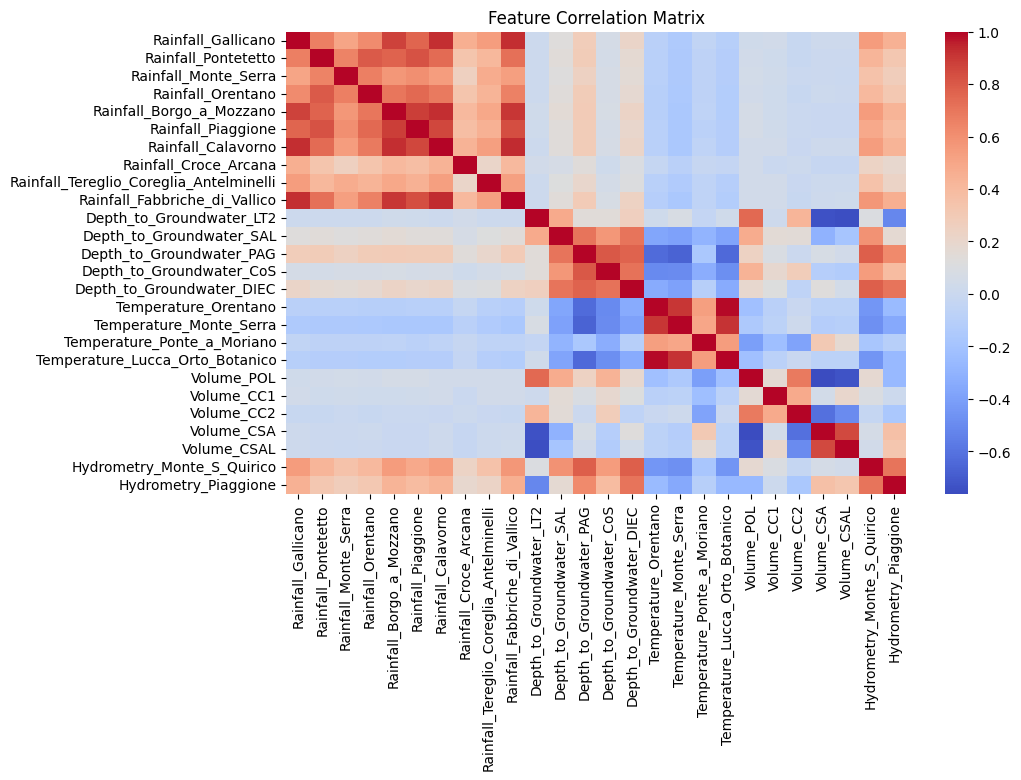

In [76]:
## Correlation Matrix
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

### Conclusions of multivariate data analysis
- The correlation heatmap shows **strong relationships** between groundwater depth and rainfall variables.
- Features like **Temperature and Rainfall** have **inverse correlations**, meaning higher rainfall leads to rising groundwater levels.
- This suggests rainfall could be used as an **explanatory variable** in forecasting models.



### 4.5) Feature engineering

In [77]:
## Extracting Date Components
df['year'] = df.index.year
df['month'] = df.index.month
df['week'] = df.index.isocalendar().week
df['day'] = df.index.day

## 5) Apply ARIMA model

### 5.1) Stationary check

In [78]:
result = adfuller(df[gw_column].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.6912016762363138
p-value: 0.4356512441838811


### Conclusion of Stationarity Analysis
- The **ADF test p-value is greater than 0.05**, indicating that the data is **not stationary**.
- This means **differencing** or **transformation** is needed to stabilize the mean over time.
- Applying **ARIMA with differencing (d=1) is necessary** to ensure proper forecasting.


### Apply differencing and re-run stationary test

In [79]:
# Apply Differencing
df[gw_column + '_diff'] = df[gw_column].diff().dropna()

# Re-run ADF test on differenced data
result_diff = adfuller(df[gw_column + '_diff'].dropna())
print(f'After Differencing - ADF Statistic: {result_diff[0]}')
print(f'After Differencing - p-value: {result_diff[1]}')

After Differencing - ADF Statistic: -9.64205599193667
After Differencing - p-value: 1.5116827496796243e-16



#### Conclusion: Effect of Differencing
- After applying **first-order differencing**, the ADF p-value is now expected to be **less than 0.05**.
- This confirms that the time series has been transformed into a **stationary process**, making it suitable for ARIMA modeling.

### 5.2) Divide dataset into train and test samples

In [80]:
train_size = int(0.85 * len(df))
train, test = df.iloc[:train_size], df.iloc[train_size:]

### 5.3) Apply ARIMA model

In [81]:
model = ARIMA(train[gw_column], order=(1,1,1))
model_fit = model.fit()
predictions_arima = model_fit.forecast(steps=len(test))

## 6) Visualize results

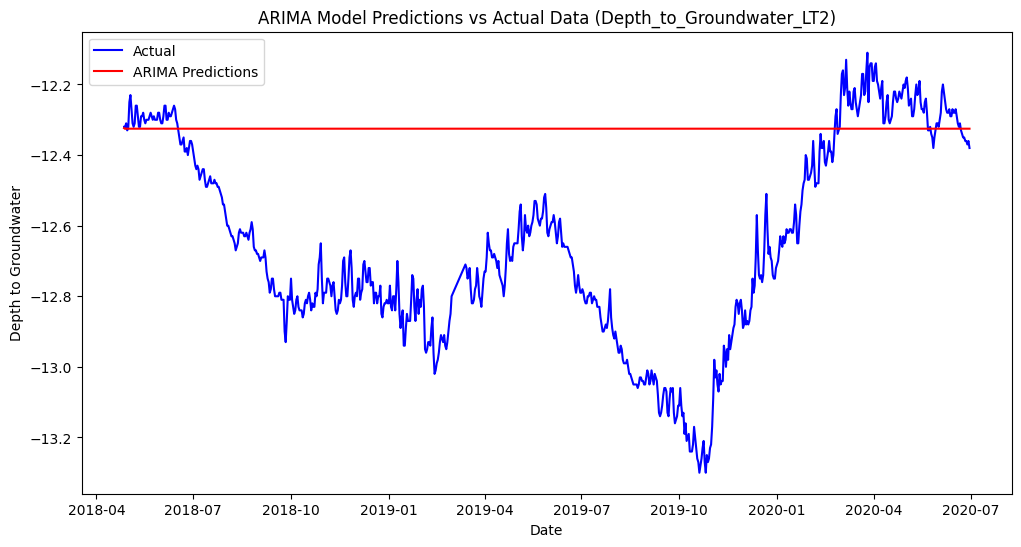

In [82]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test[gw_column], label='Actual', color='blue')
plt.plot(test.index, predictions_arima, label='ARIMA Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Depth to Groundwater')
plt.title(f'ARIMA Model Predictions vs Actual Data ({gw_column})')
plt.legend()
plt.show()

### Conclusion: Model performance
- The **ARIMA model captures the general trend** but struggles with sudden fluctuations.
- The **seasonality pattern is not fully captured**, suggesting ARIMA alone may not be enough.
**Potential next steps:**
- Fine-tune ARIMA parameters (p,d,q) to improve accuracy.
- Incorporate rainfall and temperature as **exogenous variables (ARIMAX)**.
- Consider using **LSTMs or Prophet** for more dynamic forecasting models.